In [1]:
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


In [2]:
dataset_filename = "all_sentences_processed.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [3]:
df

,scenario,source_file,original_text,preprocessed_text,label
0,Sandwich,wright04a.cha,and on the side I would spread jelly &=ges:spr...,and on the side I would spread jelly.,0
1,Speech,73-2.cha,thank_you &-uh speech no &-um can't do &-um ye...,thank you speech no cannot do yeah.,1
2,Umbrella,elman08a.cha,&=points:picture_4 and then &+buh the wade [: ...,and then the wade.,1
3,Cinderella,tap17a.cha,it's a (.) &=points:head right [: white] [* p:...,it is a right ribbon.,1
4,Cinderella,wright15a.cha,father decided to get remarried . 523775_525155,father decided to get remarried.,0
...,...,...,...,...,...
54648,Flood,wright58a.cha,I assume she was saved . 427793_428033,I assume she was saved.,0
54649,Cinderella,38-2.cha,and she goes to the ball . 2054324_2055945,and she goes to the ball.,0
54650,Umbrella,wright77a.cha,"+"" that's for sissies . 250530_251240",that is for sissies.,0
54651,Cinderella,capilouto01a.cha,and &-uh but the fairy godmother had warned he...,and but the fairy godmother had warned her tha...,0


In [3]:
# no null values 
df.isnull().sum()

scenario             0
source_file          0
original_text        0
preprocessed_text    0
label                0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

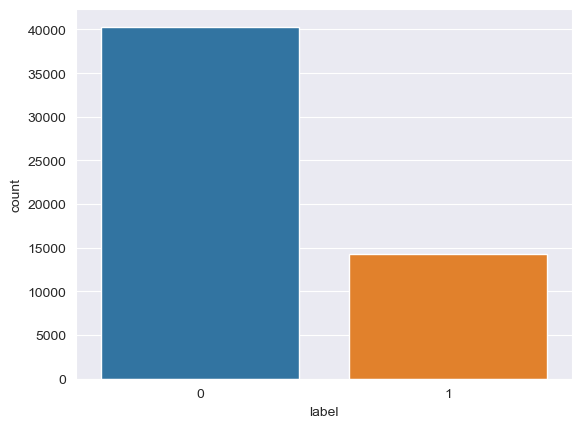

In [4]:
# A bit unbalanced
sns.countplot(x="label",data=df)

In [6]:
# # 1:1 ratio
# df1 = df[df.label==0].sample(n=len(df[df.label==1])).reset_index(drop=True)
# df2 = df[df.label==1]
# df = pd.concat([df1, df2], ignore_index=True)
# sns.countplot(x="label",data=df)

In [5]:
input_df = pd.DataFrame({"text": list(df['preprocessed_text']), "label": list(df['label'])})

In [6]:
# remove trailing whitespaces and lowercase
input_df['text'] = [x.lstrip().rstrip().lower() for x in input_df['text']]

In [7]:
input_df

,text,label
0,and on the side i would spread jelly.,0
1,thank you speech no cannot do yeah.,1
2,and then the wade.,1
3,it is a right ribbon.,1
4,father decided to get remarried.,0
...,...,...
54648,i assume she was saved.,0
54649,and she goes to the ball.,0
54650,that is for sissies.,0
54651,and but the fairy godmother had warned her tha...,0


In [8]:
# shuffle
input_df = input_df.sample(frac=1).reset_index(drop=True)

In [9]:
input_df

,text,label
0,and it appears as though he is kicking a socce...,0
1,so she ran down the steps.,0
2,let us go.,0
3,and put the jelly on top of it.,0
4,and i was a freshman.,0
...,...,...
54648,and as she was running away she drops one of h...,0
54649,and meanwhile now they are getting the firemen...,0
54650,byebye.,1
54651,so took her to the ball.,1


# Encoding # 1

In [10]:
import multiprocessing
from gensim.models import Word2Vec

In [11]:
cores = multiprocessing.cpu_count()
cores

16

In [12]:
words_in_sentences=[]
for i in input_df["text"]:
    words_in_sentences.append(i.lower().split())
words_in_sentences[0]

['and',
 'it',
 'appears',
 'as',
 'though',
 'he',
 'is',
 'kicking',
 'a',
 'soccer',
 'ball.']

In [13]:
input_df.iloc[0]

text     and it appears as though he is kicking a socce...
label                                                    0
Name: 0, dtype: object

In [14]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [15]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [16]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4138095, 12907830)

In [17]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

14876


In [18]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab), np.array(texts1)

In [19]:
transformed_text, labels1= avg_w2vec(input_df["text"], input_df["label"])

# Model fitting

In [22]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
# odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11, 13, 15],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [ ]:
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [ ]:
clf.best_params_

In [ ]:
clf.cv_results_ 

In [ ]:
result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                       pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
                       pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"])], axis=1)

In [ ]:
result_df.to_csv("knn-results.csv")

In [ ]:
knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
knn.fit(x_train, y_train)

In [ ]:
knnPickle = open('knn_pickle', 'wb')
pickle.dump(knn, knnPickle)
knnPickle.close()

# Training plots

In [ ]:
import matplotlib.pyplot as plt

cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

In [ ]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Inference

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
loaded_model = pickle.load(open('knn_pickle', 'rb'))

In [ ]:
result = loaded_model.predict(x_test)

In [ ]:
len(x_test)

In [ ]:
len(y_test)

In [ ]:
print(accuracy_score(y_test, result))

In [ ]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
print(tn, fn, tp, fp)

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)